# Backtesting tool

[*********************100%***********************]  1 of 1 completed


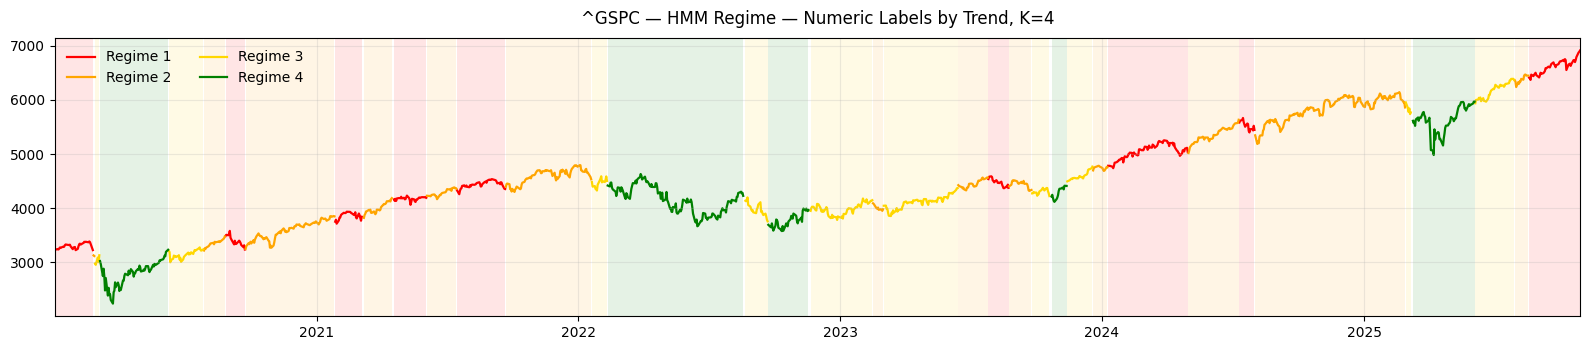


--- HMM Results (K=4) ---
Features Used: ['Level_ATR100', 'RSI']
Best log-likelihood: -10661.741356106768
   state  trend_score  mom_score  macd_score  ac1_5_score
0      1   135.107642  -0.051278   -1.590968          NaN
1      0   109.577818  -0.005555   -0.011778          NaN
2      3    32.969248   0.926573   -0.532983          NaN
3      2  -103.938794  -0.125074    2.185125          NaN


In [126]:
# -*- coding: utf-8 -*-
# Flexible HMM Regime Analysis Tool (Cleaned Version)

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
from typing import Optional, Dict, List
from matplotlib.lines import Line2D

# ---------------- Utils ----------------
def _to_series_1d(x, name=None, index=None):
    if isinstance(x, pd.DataFrame):
        if x.shape[1] == 1: x = x.iloc[:, 0]
        else: raise ValueError(f"Expected 1D Series, got DataFrame with shape {x.shape}")
    arr = np.asarray(x).ravel()
    return pd.Series(arr, index=index if index is not None else getattr(x, "index", None), name=name)

def ema(s, span):
    return _to_series_1d(s).ewm(span=span, adjust=False).mean()

def macd_signal(close, fast=12, slow=26, signal=9):
    close = _to_series_1d(close)
    macd = ema(close, fast) - ema(close, slow)
    sig  = ema(macd, signal)
    return macd.astype(float), sig.astype(float)

def rsi_wilder(close, period=14):
    close = _to_series_1d(close).astype(float)
    delta = close.diff()
    up    = delta.clip(lower=0.0)
    down  = -delta.clip(upper=0.0)
    roll_up   = up.ewm(alpha=1/period, adjust=False).mean()
    roll_down = down.ewm(alpha=1/period, adjust=False).mean()
    rs = roll_up / roll_down.replace(0, np.nan)
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi.fillna(50).astype(float)

def true_range(high, low, close):
    high, low, close = map(_to_series_1d, [high, low, close])
    prev_close = close.shift(1)
    tr = np.maximum(high - low, np.maximum((high - prev_close).abs(), (low - prev_close).abs()))
    return pd.Series(tr, index=close.index).astype(float)

def atr(series_tr, window=100):
    return _to_series_1d(series_tr).rolling(window, min_periods=max(1, window // 2)).mean().astype(float)

def rolling_autocorr_mean(ret1, window=60, max_lag=5):
    ret1 = _to_series_1d(ret1).astype(float)
    min_p = max(2, window // 2)
    cols = [ret1.rolling(window, min_periods=min_p).corr(ret1.shift(lag)) for lag in range(1, max_lag + 1)]
    if not cols: return pd.Series(np.nan, index=ret1.index)
    return pd.concat(cols, axis=1).mean(axis=1, skipna=True).astype(float)

def safe_lag_autocorr(ret, lag=1, mask=None, eps=1e-12):
    ret, r_lag = _to_series_1d(ret), _to_series_1d(ret).shift(lag)
    if mask is not None:
        mask_aligned = pd.Series(mask, index=ret.index).astype(bool)
        sel = mask_aligned & mask_aligned.shift(lag).fillna(False)
        x, y = ret[sel], r_lag[sel]
    else:
        valid = ret.notna() & r_lag.notna()
        if valid.sum() < 5: return 0.0
        x, y = ret[valid], r_lag[valid]
    if x.empty or y.empty: return 0.0
    x, y = x.dropna(), y.dropna()
    n = min(len(x), len(y))
    if n < 5 or x.var() < eps or y.var() < eps: return 0.0
    try:
        corr = np.corrcoef(x.iloc[:n], y.iloc[:n])[0, 1]
        return float(corr) if np.isfinite(corr) else 0.0
    except: return 0.0

def fit_best_hmm(X, n_states=4, n_trials=10, covariance_type='full', random_seed=42, max_iter=1000):
    best_model, best_score = None, -np.inf
    rng = np.random.RandomState(random_seed)
    for _ in range(n_trials):
        seed = rng.randint(0, 10_000)
        try:
            model = GaussianHMM(n_components=n_states, covariance_type=covariance_type,
                                n_iter=max_iter, random_state=seed, tol=1e-3)
            model.fit(X)
            current_score = model.score(X)
            if np.isfinite(current_score) and current_score > best_score:
                best_score, best_model = current_score, model
        except Exception: continue
    return best_model, best_score

# ---------------- Labeling (Numeric by Trend) ----------------
def label_states(df, states, n_states):
    info = []
    ret = np.log(df['Close']).diff()
    has_ac1_5 = 'AC1_5' in df.columns

    for k in range(n_states):
        mask = (states == k)
        if np.sum(mask) < 10:
            info.append({'state': k, 'trend_score': -np.inf})
            continue
        info.append({
            'state': k,
            'trend_score': float((df['Close'] - df['MAtrend'])[mask].mean()),
            'mom_score': float(safe_lag_autocorr(ret, lag=1, mask=mask)), # Diagnostic
            'macd_score': float(df['MACDdiff'][mask].mean()), # Diagnostic
            'ac1_5_score': float(df['AC1_5'][mask].mean()) if has_ac1_5 else np.nan # Diagnostic
        })
    info_df = pd.DataFrame(info).dropna(subset=['trend_score'])
    info_df = info_df.sort_values('trend_score', ascending=False).reset_index(drop=True)

    mapping = {int(row['state']): i + 1 for i, row in info_df.iterrows() if row['trend_score'] > -np.inf}
    all_predicted = np.unique(states)
    for k in all_predicted:
        if k not in mapping: mapping[k] = 99 # Unknown/sparse state label

    return mapping, info_df

# ---------------- Plotting (Auto regime count) ----------------

def plot_regimes_banner(
    df, ticker, title_note="Numeric Labels by Trend",
    figsize=(16, 3.6), line_lw=1.6, shade_alpha=0.10, plot_to_file: Optional[str] = None,
    *, ax=None, mode: str = "spans+price", legend_loc="upper left"
):
    if 'regime' not in df.columns:
        raise ValueError("df에 'regime' 컬럼이 없습니다.")

    recent = df.copy()
    recent['regime'] = recent['regime'].astype(int)

    unique_regs = sorted(set(recent['regime']) - {99})
    if 99 in set(recent['regime']):
        unique_regs.append(99)

    base_colors = ['red','orange','gold','green','blue','indigo','violet',
                   'grey','black','pink','brown','cyan','olive','teal','navy',
                   'firebrick','darkorange','darkgoldenrod','forestgreen','royalblue']
    palette = {r: ('lightgray' if r==99 else base_colors[i % len(base_colors)])
               for i, r in enumerate(unique_regs)}

    recent['_block'] = (recent['regime'] != recent['regime'].shift()).cumsum()

    created = False
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        created = True

    # 스팬은 맨 아래 레이어
    for _, g in recent.groupby('_block'):
        r = int(g['regime'].iloc[0])
        ax.axvspan(g.index[0], g.index[-1], color=palette.get(r, 'lightgray'),
                   alpha=shade_alpha, linewidth=0, zorder=0)

    if mode == "spans+price":
        plotted = set()
        for (_, _b), g in recent.groupby(['regime', '_block']):
            r = int(g['regime'].iloc[0])
            color = palette.get(r, 'lightgray')
            label = f"Regime {r}" if r != 99 else "Unknown"
            if r not in plotted:
                ax.plot(g.index, g['Close'], color=color, lw=line_lw, label=label, zorder=1)
                plotted.add(r)
            else:
                ax.plot(g.index, g['Close'], color=color, lw=line_lw, zorder=1)

        handles, labels = ax.get_legend_handles_labels()
        order = sorted(range(len(labels)),
                       key=lambda i: (labels[i] == "Unknown",
                                      int(labels[i].split()[-1]) if labels[i] != "Unknown" else 10**9))
        if handles:
            ax.legend([handles[i] for i in order], [labels[i] for i in order],
                      loc=legend_loc, frameon=False, ncol=max(1, len(unique_regs)//2))
    else:
        proxies = [Line2D([0],[0], color=palette[r], lw=line_lw) for r in unique_regs]
        labels  = [f"Regime {r}" if r != 99 else "Unknown" for r in unique_regs]
        if proxies:
            ax.legend(proxies, labels, loc=legend_loc, frameon=False,
                      ncol=max(1, len(unique_regs)//2))

    ax.set_title(f"{ticker} — HMM Regime — {title_note}", pad=10)
    ax.grid(True, alpha=0.25, zorder=2)  # 그리드는 위쪽에
    ax.set_xlim(df.index[0], df.index[-1])

    if created:
        plt.tight_layout()
        if plot_to_file:
            plt.savefig(plot_to_file); plt.close()
        else:
            plt.show()

    return ax, {"palette": palette, "unique_regs": unique_regs}

# ===== Add this helper once =====
from matplotlib.lines import Line2D

def draw_regime_spans(
    ax,
    idx,                      # DatetimeIndex (e.g., price.index)
    regime,                   # pd.Series or array-like of ints aligned to idx
    n_states=None,            # unused (kept for compatibility)
    *,
    shade_alpha: float = 0.12,
    price_for_legend=None,    # kept for compatibility; we use legend proxies
    line_lw: float = 1.4,
    legend_loc: str = "upper left"
):
    """Draw colored regime spans (and legend) onto an existing Axes."""

    # 1) align & sanitize
    reg = pd.Series(regime, index=idx).astype(int)
    unique_regs = sorted(set(reg.dropna()) - {99})
    if 99 in set(reg):
        unique_regs.append(99)

    # 2) palette (Unknown=99 -> lightgray)
    base_colors = ['red','orange','gold','green','blue','indigo','violet',
                   'grey','black','pink','brown','cyan','olive','teal','navy',
                   'firebrick','darkorange','darkgoldenrod','forestgreen','royalblue']
    palette = {r: ('lightgray' if r==99 else base_colors[i % len(base_colors)])
               for i, r in enumerate(unique_regs)}

    # 3) contiguous blocks
    block = (reg != reg.shift()).cumsum()
    for _, g in pd.DataFrame({"reg": reg, "_block": block}).groupby("_block"):
        r = int(g["reg"].iloc[0])
        span_idx = g.index
        ax.axvspan(span_idx[0], span_idx[-1],
                   color=palette.get(r, "lightgray"),
                   alpha=shade_alpha, linewidth=0, zorder=0)

    # 4) legend (proxies)
    proxies = [Line2D([0],[0], color=palette[r], lw=line_lw) for r in unique_regs]
    labels  = [f"Regime {r}" if r != 99 else "Unknown" for r in unique_regs]
    if proxies:
        ax.legend(proxies, labels, loc=legend_loc, frameon=False,
                  ncol=max(1, len(unique_regs)//2))

# ---------------- Pipeline ----------------
def run_hmm(
    ticker="^KS11", start="1990-01-01", plot_start="2020-01-01",
    n_states=4, n_trials=12, ma_window=200, rsi_period=14, ac_window=60,
    atr_clip_window=252, smoothing_window_mr=3,
    use_slope=True, use_ac=True, use_rsi=True, use_volume=True
):
    try:
        raw = yf.download(ticker, start=start, auto_adjust=True, interval="1d")
        if raw.empty: raise RuntimeError("Data download failed.")
    except Exception as e:
        print(f"Data download failed: {e}"); return None, None, None, None

    processed_data = {}
    cols_needed = ['Close', 'High', 'Low']
    if use_volume: cols_needed.append('Volume')

    for col in cols_needed:
        if col not in raw.columns:
            if col == 'Volume': use_volume = False; continue
            else: print(f"Error: Required column '{col}' not found."); return None, None, None, None
        try:
            series = _to_series_1d(raw[col], name=col)
            series = pd.to_numeric(series, errors='coerce')
            if series.isnull().all(): raise ValueError("All values NaN after numeric conversion.")
            processed_data[col.lower()] = series
        except Exception as e:
             print(f"Error processing column '{col}': {e}")
             if col == 'Volume': use_volume = False; continue
             else: return None, None, None, None

    close = processed_data['close']
    high  = processed_data['high']
    low   = processed_data['low']
    volume = processed_data.get('volume', None)

    df = pd.DataFrame({"Close": close}).dropna(subset=['Close'])
    high, low = high.reindex(df.index), low.reindex(df.index)
    if volume is not None: volume = volume.reindex(df.index)

    # --- Indicators ---
    df['MAtrend'] = df['Close'].rolling(ma_window, min_periods=max(1, ma_window//3)).mean()
    tr = true_range(high, low, df['Close'])
    atr100 = atr(tr, window=100)
    atr100_robust = atr100.copy() # Default to unclipped
    if len(atr100.dropna()) >= 60:
         p10 = atr100.rolling(atr_clip_window, min_periods=60).quantile(0.10).fillna(method='bfill').fillna(0.01)
         p90 = atr100.rolling(atr_clip_window, min_periods=60).quantile(0.90).fillna(method='bfill').fillna(1.0)
         if not (p10.isnull().all() or p90.isnull().all()): # Check if quantiles are valid
             atr100_robust = atr100.clip(lower=p10, upper=p90)
    atr100_robust = atr100_robust.replace(0, np.nan).fillna(method='ffill').fillna(method='bfill').fillna(1e-6).reindex(df.index)

    macd, sig = macd_signal(df['Close'])
    df['MACDdiff'] = (macd - sig).astype(float)
    ret1 = np.log(df['Close']).diff()
    ac = rolling_autocorr_mean(ret1, window=ac_window, max_lag=5) if use_ac else None
    rsi = rsi_wilder(df['Close'], period=rsi_period) if use_rsi else None

    # --- Build Features ---
    feats_dict = {'Level_ATR100': (df['Close'] - df['MAtrend']) / atr100_robust}
    if use_slope: feats_dict['Slope_ATR100'] = df['MACDdiff'] / atr100_robust
    if use_ac and ac is not None: feats_dict['AC1_5'] = ac
    if use_rsi and rsi is not None: feats_dict['RSI'] = rsi
    if use_volume and volume is not None:
        vol_atr = (volume / atr100_robust).replace([np.inf, -np.inf], np.nan)
        feats_dict['Volume_ATR'] = vol_atr
    feats = pd.DataFrame(feats_dict)

    # --- Smoothing ---
    if smoothing_window_mr > 1:
        for col in ['RSI', 'AC1_5', 'Volume_ATR']:
            if col in feats: feats[col] = feats[col].rolling(smoothing_window_mr, min_periods=1).mean()

    feats = feats.dropna()
    if feats.empty: print("Error: No valid features after NaN removal."); return None, None, None, None

    # --- Align, Scale, Fit ---
    common_index = df.index.intersection(feats.index)
    df = df.loc[common_index].copy()
    feats = feats.loc[common_index].copy()
    if 'AC1_5' in feats: df['AC1_5'] = feats['AC1_5'] # For diagnostics
    X = StandardScaler().fit_transform(feats.values)
    if X.shape[0] < n_states: print(f"Error: Not enough data ({X.shape[0]}) for HMM."); return None, None, None, None

    model, best_score = fit_best_hmm(X, n_states=n_states, n_trials=n_trials)
    if model is None: print("HMM fitting failed."); return None, None, None, None

    try: states = model.predict(X)
    except Exception as e: print(f"HMM prediction failed: {e}"); return None, None, None, None

    # --- Label, Plot, Diagnostics ---
    mapping, summary = label_states(df, states, n_states=n_states)
    df['state']  = states
    df['regime'] = [mapping.get(s, 99) for s in states]

    recent = df.loc[df.index >= pd.to_datetime(plot_start)].copy()
    if not recent.empty:
        # n_states를 넘기지 않고, df 안의 레짐 개수를 함수가 자동 파악
        plot_regimes_banner(recent, ticker=ticker,
                            title_note=f"Numeric Labels by Trend, K={n_states}")

    print(f"\n--- HMM Results (K={n_states}) ---")
    print(f"Features Used: {list(feats.columns)}")
    print("Best log-likelihood:", best_score)
    print_cols = ['state', 'trend_score', 'mom_score', 'macd_score']
    if 'ac1_5_score' in summary.columns: print_cols.append('ac1_5_score')
    if not summary.empty: print(summary.sort_values('trend_score', ascending=False)[print_cols])
    else: print("Summary table could not be generated.")

    feats_scaled = pd.DataFrame(X, index=df.index, columns=feats.columns)
    return df, feats_scaled, model, mapping

# --------- Run Configuration ---------
if __name__ == "__main__":
    # --- 기본 설정 ---
    N_STATES_TO_RUN = 4         # <<< 레짐(상태) 개수 (K) 설정
    TICKER_TO_RUN = "^GSPC"      # <<< 분석할 티커 설정
    START_DATE = "1995-01-01"
    PLOT_START = "2020-01-01"
    MA_WINDOW = 120             # <<< 이평선 기간 설정 (Level 피처용)
    AC_WINDOW = 60              # <<< AC1_5 피처용 롤링 기간 (use_ac=True일 때만)

    # --- 피처 사용 여부 토글 ---
    USE_SLOPE = False
    USE_AC = False
    USE_RSI = True
    USE_VOLUME = False

        # --- HMM 실행 ---
    df, feats_scaled, model, mapping = run_hmm(
        ticker=TICKER_TO_RUN,
        start=START_DATE,
        plot_start=PLOT_START,
        n_states=N_STATES_TO_RUN,
        n_trials=20,
        ma_window=MA_WINDOW,
        rsi_period=14,
        ac_window=AC_WINDOW,
        smoothing_window_mr=1,
        use_slope=USE_SLOPE,
        use_ac=USE_AC,
        use_rsi=USE_RSI,
        use_volume=USE_VOLUME
    )

    if df is None:
        raise SystemExit("HMM 실행 실패: df가 None입니다.")

    # 레짐 인덱싱 버전 생성
    df_ix = with_regime_index(df)

In [127]:
def regime_to_column(df_ix: pd.DataFrame, drop_block=False) -> pd.DataFrame:
    out = df_ix.copy()
    # 현재 인덱스 순서가 (regime, regime_block, date/Date)라면
    # 앞의 두 레벨만 컬럼으로 내리고, 마지막(날짜)은 인덱스로 유지
    out = out.reset_index(level=[0, 1])  # 0=regime, 1=regime_block
    # 보기 좋게 인덱스 이름
    out.index.name = out.index.name or 'Date'
    if drop_block and 'regime_block' in out.columns:
        out = out.drop(columns=['regime_block'])
    return out

# 사용
df_out = regime_to_column(df_ix, drop_block=False)
print(df_out.head())

            regime  regime_block       Close     MAtrend  MACDdiff  state
Date                                                                     
1995-04-17       1             3  506.130005  483.966714 -0.297947      1
1995-04-18       1             3  505.369995  484.255948 -0.500787      1
1995-04-19       1             3  504.920013  484.531469 -0.675212      1
1995-04-20       1             3  505.290009  484.804607 -0.768814      1
1995-04-21       1             3  508.489990  485.112210 -0.624497      1


In [128]:
df_out

,regime,regime_block,Close,MAtrend,MACDdiff,state
Date,,,,,,
1995-04-17,1,3,506.130005,483.966714,-0.297947,1
1995-04-18,1,3,505.369995,484.255948,-0.500787,1
1995-04-19,1,3,504.920013,484.531469,-0.675212,1
1995-04-20,1,3,505.290009,484.804607,-0.768814,1
1995-04-21,1,3,508.489990,485.112210,-0.624497,1
...,...,...,...,...,...,...
2025-05-29,4,176,5912.169922,5805.817912,-1.927982,2
2025-05-30,4,176,5911.689941,5804.361243,-3.500551,2
2025-06-02,4,176,5935.939941,5803.201493,-3.612469,2


In [251]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Callable, Dict, Optional
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, ScalarFormatter
from pandas.api.types import is_integer_dtype, is_float_dtype

# -----------------------------
# 0) 유틸: 레짐 라벨 → 시그널 매핑
# -----------------------------
REGIME_MAP = {
    "Momentum": 1,
    "MeanReversion": -1,
    "RandomWalk": 0,
}

def map_regime_to_signal(regime: pd.Series) -> pd.Series:
    """
    df_out['regime'] (str 또는 int)를 {-1,0,1}로 변환.
    대소문자/공백/언더스코어 관대 처리.
    이미 -1/0/1이면 그대로 반환.
    """
    def _norm(x):
        if isinstance(x, (int, float)) and x in (-1, 0, 1):
            return int(x)
        key = str(x).strip().lower().replace("_","")
        if key in ("momentum", "momo"): return 1
        if key in ("meanreversion", "mean-reversion", "mr"): return -1
        if key in ("randomwalk", "rw"): return 0
        return np.nan  # 알 수 없는 레이블은 NaN
    sig = regime.map(_norm).astype("float")
    return sig

# ------------------------------------
# 1) 백테스트 설정 및 핵심 로직 (프로토)
# ------------------------------------
@dataclass
class BTConfig:
    init_capital: float = 1_000_000.0
    fee_bps: float = 5.0        # 왕복 거래비용(bps)
    slip_bps: float = 0.0       # 슬리피지(bps)
    max_leverage: float = 1.0   # |포지션| 상한
    allow_shorts: bool = True   # 공매도 허용
    # 전략 파라미터
    mom_lookback: int = 20
    mr_z_window: int = 60
    mr_smooth: int = 10         # MR 신호 스무딩(부호 평균)

def _bps_to_decimal(bps: float) -> float:
    return bps / 10_000.0

def clip_leverage(sig: pd.Series, max_leverage: float, allow_shorts: bool) -> pd.Series:
    if not allow_shorts:
        sig = sig.clip(lower=0)
    return sig.clip(-max_leverage, max_leverage)

# --- 레짐별 전략 로직 (심플 베이스라인) ---
def strat_momentum(prices: pd.Series, returns: pd.Series, cfg: BTConfig) -> pd.Series:
    # lookback 누적수익률 부호 추종
    roll = (1 + returns).rolling(cfg.mom_lookback).apply(np.prod, raw=True) - 1.0
    sig = np.sign(roll).replace(0, np.nan).fillna(method="ffill").fillna(0.0)
    return clip_leverage(sig, cfg.max_leverage, cfg.allow_shorts)

def strat_mean_reversion(prices: pd.Series, returns: pd.Series, cfg: BTConfig) -> pd.Series:
    ma  = prices.rolling(cfg.mr_z_window).mean()
    std = prices.rolling(cfg.mr_z_window).std(ddof=0)
    z = (prices - ma) / std
    # z>0 과매수→숏, z<0 과매도→롱
    raw = -np.sign(z)
    if cfg.mr_smooth > 1:
        raw = raw.rolling(cfg.mr_smooth).mean().apply(lambda x: np.sign(x) if pd.notna(x) else np.nan)
    sig = raw.replace(0, np.nan).fillna(method="ffill").fillna(0.0)
    return clip_leverage(sig, cfg.max_leverage, cfg.allow_shorts)

def strat_random_walk(prices: pd.Series, returns: pd.Series, cfg: BTConfig) -> pd.Series:
    # 엣지 없음 → 기본은 관망(0)
    return pd.Series(0.0, index=prices.index)

from typing import Iterable

def backtest_regime_switch(
    prices: pd.Series,
    regime_signal: Optional[pd.Series] = None,
    *,
    regime_num: Optional[pd.Series] = None,
    strategy_map: Optional[Dict[int, Callable[[pd.Series, pd.Series, BTConfig], pd.Series]]] = None,
    start: Optional[str] = None,
    end: Optional[str] = None,
    warmup_bars: int = 100,

    config: Optional[BTConfig] = None,
    custom_strategies: Optional[Dict[int, Callable[[pd.Series, pd.Series, BTConfig], pd.Series]]] = None,
    exec_shift: int = 0,
    prob_gate: Optional[pd.Series] = None,
    prob_threshold: float = 0.0,
    trail_pct: Optional[float] = 0.05,
    cool_off_days: int = 0,
    fee_bps: Optional[float] = None,    
    slip_bps: Optional[float] = None,   
) -> Dict[str, pd.DataFrame]:

    cfg = (config or BTConfig())
    if fee_bps is not None:
        cfg.fee_bps = float(fee_bps)   # 편도 bps 권장(주석으로 명시)
    if slip_bps is not None:
        cfg.slip_bps = float(slip_bps) # 편도 bps 권장
    
    # ---------- 기간 윈도우 + 워밍업 ----------
    full_idx = pd.DatetimeIndex(prices.index).sort_values().unique()
    win_idx  = _normalize_window(full_idx, start, end)
    
    if start or end:
        if len(win_idx) == 0:
            raise ValueError("선택한 기간에 데이터가 없습니다.")
        # 워밍업: 시작 전 N개 바 포함
        start_pos = full_idx.get_indexer([win_idx.min()], method="nearest")[0]
        end_pos   = full_idx.get_indexer([win_idx.max()], method="nearest")[0]
        calc_idx  = full_idx[max(0, start_pos - warmup_bars) : end_pos + 1]
    else:
        win_idx = full_idx
        calc_idx = full_idx
    
    # 모든 입력 시리즈를 calc_idx로 정렬/재색인
    prices = pd.to_numeric(pd.Series(prices).reindex(calc_idx), errors="coerce").astype(float)
    
    if regime_signal is not None:
        regime_signal = pd.Series(regime_signal).reindex(calc_idx)
    
    if regime_num is not None:
        regime_num = pd.Series(regime_num).reindex(calc_idx)
    
    if prob_gate is not None:
        prob_gate = pd.Series(prob_gate).reindex(calc_idx)
    
    # 이제 ret 계산 (calc_idx 기준)
    ret = prices.pct_change().fillna(0.0)

    # ---------- 전략 디스패처 준비 ----------
    # (A) 기존 {-1,0,1} 경로
    base_dispatcher = { 1: strat_momentum, -1: strat_mean_reversion, 0: strat_random_walk }
    if custom_strategies:
        base_dispatcher.update(custom_strategies)

    # (B) 신규 1..K 경로: 사용자 제공 strategy_map 사용, 누락 레짐은 관망 처리
    def _build_dispatch_for_regimes(reg_ids: Iterable[int]) -> Dict[int, Callable]:
        disp = {}
        for r in reg_ids:
            if strategy_map and r in strategy_map:
                disp[r] = strategy_map[r]
            else:
                disp[r] = strat_random_walk   # 기본: 관망
        return disp

    # ---------- 레짐별 포지션 계산 ----------
    if regime_num is not None:
        # 모드 B: 정수 레짐
        reg = pd.to_numeric(regime_num, errors="coerce").astype("Int64").reindex(prices.index)
        uniq_regs = sorted(set(reg.dropna()) - {99})
        disp = _build_dispatch_for_regimes(uniq_regs)

        # 각 레짐의 "전략 포지션 시리즈" 미리 계산
        pos_by_regime = {r: disp[r](prices, ret, cfg) for r in uniq_regs}
        pos_target = pd.Series(0.0, index=prices.index)
        for r in uniq_regs:
            mask = (reg == r).astype(float)
            pos_target = pos_target + mask * pos_by_regime[r]

        pos_target = pos_target.fillna(0.0)
        
        # 게이트(확률 임계) → 관망 처리
        if prob_gate is not None and prob_threshold > 0:
            pos_target = pos_target.where(prob_gate.reindex(prices.index) >= prob_threshold, 0.0)
        
        # ✅ 최종 안전클립 (사용자 전략이 -1..1을 벗어나도 방어)
        pos_target = clip_leverage(pos_target, cfg.max_leverage, cfg.allow_shorts)
        
        meta_dict = {"mode": "K-regimes", "used_regimes": uniq_regs}
        
    else:
        # 모드 A: 기존 {-1,0,1}
        assert regime_signal is not None, "regime_signal 또는 regime_num 중 하나는 제공해야 합니다."
        regsig = regime_signal.reindex(prices.index).astype(float)

        pos_mom = base_dispatcher[1](prices, ret, cfg)
        pos_mr  = base_dispatcher[-1](prices, ret, cfg)
        pos_rw  = base_dispatcher[0](prices, ret, cfg)

        regime_use = regsig.copy()
        if prob_gate is not None and prob_threshold > 0:
            regime_use = regime_use.where(prob_gate.reindex(prices.index) >= prob_threshold, 0.0)

        pos_target = (
            (regime_use == 1).astype(float)  * pos_mom +
            (regime_use == -1).astype(float) * pos_mr  +
            (regime_use == 0).astype(float)  * pos_rw
        ).fillna(0.0)
        
        pos_target = clip_leverage(pos_target, cfg.max_leverage, cfg.allow_shorts)
        
        meta_dict = {"mode": "tri-signal", "used_regimes": [ -1, 0, 1 ]}

    # ---------- 체결 시차/스톱/거래비용/성과 (기존 로직 동일) ----------
    pos_exec = pos_target.shift(exec_shift).ffill().fillna(0.0)

    def apply_trailing_stop(prices: pd.Series, pos_exec: pd.Series,
                            trail_pct: float = 0.05, cool_off_days: int = 0):
        idx = pos_exec.index
        pos_out = pos_exec.copy()
        cur_pos = 0.0
        entry_price = None
        peak = None
        trough = None
        cooldown = 0
        logs = []
        for i, t in enumerate(idx):
            desired = pos_exec.iloc[i]
            price = prices.loc[t]
            if cooldown > 0:
                pos_out.iloc[i] = 0.0; cooldown -= 1; continue
            if cur_pos == 0.0 and desired != 0.0:
                cur_pos = desired; entry_price = price; peak = price; trough = price
                pos_out.iloc[i] = desired; continue
            if cur_pos != 0.0:
                if cur_pos > 0:
                    peak = max(peak, price) if peak is not None else price
                    stop_price = peak * (1.0 - trail_pct)
                    if price <= stop_price:
                        pos_out.iloc[i] = 0.0
                        logs.append({"time": t, "price": price, "stop_price": stop_price, "side": "LONG"})
                        cur_pos = 0.0; entry_price = None; peak = trough = None; cooldown = cool_off_days; continue
                else:
                    trough = min(trough, price) if trough is not None else price
                    stop_price = trough * (1.0 + trail_pct)
                    if price >= stop_price:
                        pos_out.iloc[i] = 0.0
                        logs.append({"time": t, "price": price, "stop_price": stop_price, "side": "SHORT"})
                        cur_pos = 0.0; entry_price = None; peak = trough = None; cooldown = cool_off_days; continue
            pos_out.iloc[i] = desired
            if cur_pos == 0.0 and desired != 0.0:
                cur_pos = desired; entry_price = price; peak = price; trough = price
            elif desired == 0.0:
                cur_pos = 0.0; entry_price = None; peak = trough = None
            elif np.sign(desired) != np.sign(cur_pos):
                cur_pos = desired; entry_price = price; peak = price; trough = price
        trail_log = (pd.DataFrame(logs).set_index("time")
                     if logs else pd.DataFrame(columns=["time","price","stop_price","side"]))
        return pos_out, trail_log

    if trail_pct is not None and trail_pct > 0:
        pos_exec, trail_log = apply_trailing_stop(prices, pos_exec, trail_pct=trail_pct, cool_off_days=cool_off_days)
    else:
        trail_log = pd.DataFrame(columns=["time","price","stop_price","side"])

    dpos  = pos_exec.diff().abs().fillna(pos_exec.abs()).astype(float)
    tc    = _bps_to_decimal(cfg.fee_bps + cfg.slip_bps)
    gross = (pos_exec * ret).astype(float).fillna(0.0)
    cost  = (dpos * tc).astype(float).fillna(0.0)
    net   = (gross - cost).astype(float)
    equity = (1 + net).cumprod() * cfg.init_capital

    trades = []
    last = 0.0
    for t in prices.index:
        p = pos_exec.loc[t]
        if p != last:
            trades.append({
                "time": t, "price": prices.loc[t],
                "prev_pos": last, "new_pos": p,
                "turnover": abs(p - last), "est_cost": abs(p - last) * tc
            })
            last = p
    trade_log = pd.DataFrame(trades).set_index("time") if trades else pd.DataFrame(
        columns=["time","price","prev_pos","new_pos","turnover","est_cost"]
    )

    def _stats(r: pd.Series, eq: pd.Series, rf: float = 0.0, periods_per_year: int = 252) -> pd.Series:
        if isinstance(eq.index, pd.DatetimeIndex): n_days = (eq.index[-1] - eq.index[0]).days
        else: n_days = len(eq)
        years = max(n_days/365.25, 1e-9)
        cagr = (eq.iloc[-1]/eq.iloc[0])**(1/years) - 1 if len(eq) > 1 else 0.0
        mu  = r.mean(); sd = r.std(ddof=0)
        sharpe  = (mu / sd) * np.sqrt(periods_per_year) if sd > 0 else np.nan
        mdd = (eq/eq.cummax() - 1).min()
        downside = r[r < rf] - rf; dd_std = downside.std(ddof=0)
        sortino = (mu - rf) / dd_std * np.sqrt(periods_per_year) if dd_std > 0 else np.nan
        calmar = cagr / abs(mdd) if mdd < 0 else np.nan
        return pd.Series({"CAGR": cagr, "Sharpe(ann.)": sharpe, "Sortino(ann.)": sortino,
                          "Calmar": calmar, "MaxDD": mdd, "DailyMean": mu, "DailyStd": sd})

    summary = _stats(net, equity)
    result = pd.DataFrame({
        "price": prices, "ret": ret,
        "pos_target": pos_target, "pos_exec": pos_exec,
        "turnover": dpos, "cost": cost, "gross": gross, "net": net, "equity": equity
    })
    result = result.reindex(win_idx)
    
    if not trade_log.empty:
        trade_log = trade_log.loc[(trade_log.index >= win_idx.min()) & (trade_log.index <= win_idx.max())]
    
    if not trail_log.empty and isinstance(trail_log.index, pd.DatetimeIndex):
        trail_log = trail_log.loc[(trail_log.index >= win_idx.min()) & (trail_log.index <= win_idx.max())]
    
    meta_out = dict(meta_dict)
    meta_out.update({
        "window": (start, end),
        "warmup_bars": warmup_bars,
        "calc_span": (calc_idx.min(), calc_idx.max()),
        "return_span": (win_idx.min(), win_idx.max()),
        "init_capital": float(cfg.init_capital),
        "fee_bps": float(cfg.fee_bps),
        "slip_bps": float(cfg.slip_bps),
    })


    return {
        "result": result,
        "trades": trade_log,
        "summary": summary.to_frame("value"),
        "trailing_stops": trail_log,
        "meta": meta_out
    }

def _round_trips_from_trades(result: pd.DataFrame, trades: pd.DataFrame):
    """
    trade 로그(포지션 변경 시점)를 이용해 라운드트립(진입→청산)을 추출.
    per-trade 수익률은 result['net']를 구간 곱으로 계산.
    reversal(+1→-1 등)은 '청산' 후 같은 타임스탬프에 '재진입'으로 분해 처리.
    """
    if trades.empty:
        cols = ["entry_time","exit_time","side","entry_price","exit_price","ret_trade"]
        return pd.DataFrame(columns=cols)

    tr = trades.copy().sort_index()
    res = result.copy()
    res["one_plus_net"] = 1.0 + res["net"]

    rows = []
    cur_pos = 0.0
    entry_time = None
    entry_price = None

    for t, row in tr.iterrows():
        prev_p, new_p, price = row["prev_pos"], row["new_pos"], row["price"]

        # reversal: exit old, enter new (same timestamp)
        if prev_p != 0.0 and new_p != 0.0 and np.sign(prev_p) != np.sign(new_p):
            # exit part
            if entry_time is not None:
                s = res.index.get_loc(entry_time)
                e = res.index.get_loc(t)
                # 구간 순수익률 (entry 직후 ~ exit 시점 포함)
                r = res["one_plus_net"].iloc[s+1:e+1].prod() - 1.0
                rows.append({
                    "entry_time": entry_time,
                    "exit_time": t,
                    "side": "LONG" if prev_p > 0 else "SHORT",
                    "entry_price": entry_price,
                    "exit_price": price,
                    "ret_trade": r
                })
            # start new entry immediately
            entry_time = t
            entry_price = price
            cur_pos = new_p
            continue

        # normal changes
        if prev_p == 0.0 and new_p != 0.0:
            # entry
            entry_time = t
            entry_price = price
            cur_pos = new_p
        elif prev_p != 0.0 and new_p == 0.0:
            # exit
            if entry_time is not None:
                s = res.index.get_loc(entry_time)
                e = res.index.get_loc(t)
                r = res["one_plus_net"].iloc[s+1:e+1].prod() - 1.0
                rows.append({
                    "entry_time": entry_time,
                    "exit_time": t,
                    "side": "LONG" if prev_p > 0 else "SHORT",
                    "entry_price": entry_price,
                    "exit_price": price,
                    "ret_trade": r
                })
            entry_time = None
            entry_price = None
            cur_pos = 0.0
        else:
            cur_pos = new_p

    cols = ["entry_time","exit_time","side","entry_price","exit_price","ret_trade"]
    return pd.DataFrame(rows, columns=cols)

def _normalize_window(idx: pd.DatetimeIndex,
                      start: Optional[str], end: Optional[str]) -> pd.DatetimeIndex:
    """
    DatetimeIndex가 비단조/중복/타임존 불일치/정확 라벨 부재여도
    KeyError 없이 안전하게 기간 인덱스를 반환.
    """
    if not isinstance(idx, pd.DatetimeIndex):
        raise TypeError("Index must be a DatetimeIndex")

    # 1) 정렬 + 고유화
    idx_mon = pd.DatetimeIndex(idx).sort_values().unique()

    # 2) 타임존 맞춤
    tz = idx_mon.tz
    s = pd.to_datetime(start) if start else None
    e = pd.to_datetime(end)   if end   else None
    if tz is not None:
        if s is not None and s.tzinfo is None: s = s.tz_localize(tz)
        if e is not None and e.tzinfo is None: e = e.tz_localize(tz)
    else:
        if s is not None and s.tzinfo is not None: s = s.tz_convert(None)
        if e is not None and e.tzinfo is not None: e = e.tz_convert(None)

    # 3) 불리언 마스크로 between
    mask = pd.Series(True, index=idx_mon)
    if s is not None: mask &= (idx_mon >= s)
    if e is not None: mask &= (idx_mon <= e)

    return idx_mon[mask]


#### 시각화 ####
def overlay_trailing_stops(ax, bt, *, use_exec_price: bool = True,
                           color="black", s=70, alpha=0.7, zorder=10, linewidths=1.5):
    if "trailing_stops" not in bt:
        return
    ts = bt["trailing_stops"]
    if ts.empty:
        return

    y = ts["price"] if use_exec_price else ts["stop_price"]
    ax.scatter(
        ts.index, y,
        marker=".", s=s, color=color, alpha=alpha,
        zorder=zorder, linewidths=linewidths, label="Trailing stop"
    )



def plot_backtest_with_trades_rainbow(
    bt: dict, df_out: pd.DataFrame,
    *,
    price_col: str = "Close",
    title_prefix: str = "Regime-Switch Backtest",
    shade_alpha: float = 0.12,
    show_regime: bool = True,
    ticker: str = "",
    start: Optional[str] = None,
    end: Optional[str] = None
):
    """
    bt: run_backtest(...) 결과 dict
    df_out: (Date index, columns 포함: price_col, regime)
    start/end: 'YYYY-MM-DD' 등 기간 문자열 (없으면 전체)
    """
    res_full = bt["result"]
    trades_full = bt["trades"] if "trades" in bt else pd.DataFrame()
    ts_full = bt.get("trailing_stops", pd.DataFrame())

    # 안전 윈도우 인덱스
    idx_win = _normalize_window(res_full.index, start, end)
    if len(idx_win) == 0:
        raise ValueError("선택한 기간에 데이터가 없습니다.")

    # 윈도우 적용 (라벨 부재에도 안전하게 reindex)
    result = res_full.reindex(idx_win).copy()
    price_raw = df_out.reindex(idx_win)[price_col]
    if isinstance(price_raw, pd.DataFrame):         # 동명 컬럼 다중 존재 방지
        price_raw = price_raw.iloc[:, 0]
    price  = pd.to_numeric(price_raw, errors="coerce").astype(float)


    # trades / trailing stops도 같은 기간으로
    if not trades_full.empty:
        tmask = (trades_full.index >= idx_win.min()) & (trades_full.index <= idx_win.max())
        trades = trades_full.loc[tmask].copy()
    else:
        trades = trades_full

    if not ts_full.empty and isinstance(ts_full.index, pd.DatetimeIndex):
        tsmask = (ts_full.index >= idx_win.min()) & (ts_full.index <= idx_win.max())
        ts_win = ts_full.loc[tsmask].copy()
    else:
        ts_win = pd.DataFrame(columns=["time","price","stop_price","side"]).set_index(
            pd.DatetimeIndex([], name="time")
        )

    # ---- Plot: Price & Trades (+Regime spans) ----
    fig, ax = plt.subplots(figsize=(14, 5))

    if show_regime and ("regime" in df_out.columns):
        reg_ser = df_out.reindex(idx_win)["regime"].astype(int)
        # draw_regime_spans: 네가 가진 함수 사용
        draw_regime_spans(
            ax=ax, idx=idx_win, regime=reg_ser,
            shade_alpha=shade_alpha, line_lw=1.4
        )

    # 가격 라인 (1회만)
    ax.plot(idx_win, price.values, label="Price", lw=1.4, color="tab:blue", zorder=1)

    # Entry / Exit / Reversal 마커
    if not trades.empty:
        ent = trades[(trades["prev_pos"]==0) & (trades["new_pos"]!=0)]
        exi = trades[(trades["prev_pos"]!=0) & (trades["new_pos"]==0)]
        rev = trades[(trades["prev_pos"]!=0) & (trades["new_pos"]!=0) &
                     (np.sign(trades["prev_pos"]) != np.sign(trades["new_pos"]))]

        ax.scatter(ent.index, ent["price"], marker="^", s=70, label="Entry",
                   zorder=6, color='green')
        ax.scatter(exi.index, exi["price"], marker="v", s=70, label="Exit",
                   zorder=6, color='red')
        ax.scatter(rev.index, rev["price"], marker="o", s=46, label="Reversal",
                   zorder=6, color='gold', alpha=0.8)

    # Trailing stop 점 표시 (네가 가진 overlay_trailing_stops 사용)
    if not ts_win.empty:
        overlay_trailing_stops(
            ax, {"trailing_stops": ts_win},
            color="black", s=70, alpha=0.85, zorder=10, linewidths=1.5
        )

    ax.set_title(f"{title_prefix} — Price & Trades" + (f" [{ticker}]" if ticker else ""))
    ax.set_xlabel("Date"); ax.set_ylabel("Price")
    ax.grid(True, alpha=0.3, zorder=2)

    # 범례 중복 제거
    h, l = ax.get_legend_handles_labels()
    uniq = dict(zip(l, h))
    if uniq:
        ax.legend(uniq.values(), uniq.keys(), loc="best", frameon=False)

    plt.tight_layout(); plt.show()

    # ---- Plot: Trade P&L bars (round-trip) ----
    rt = _round_trips_from_trades(result, trades)
    if not rt.empty:
        fig, ax = plt.subplots(figsize=(14, 3.8))
        ax.bar(rt["exit_time"].astype(str), rt["ret_trade"].values)
        ax.axhline(0, linewidth=1)
        ax.set_title(f"{title_prefix} — Trade P&L (net, round-trip)")
        ax.set_xlabel("Exit time"); ax.set_ylabel("Return per trade")
        ax.tick_params(axis="x", rotation=60)
        ax.grid(True, axis="y", alpha=0.3)
        plt.tight_layout(); plt.show()

    return rt

def plot_cum_return_after(bt, *, title="Cumulative Return (net) vs Buy&Hold",
                          show_buyhold=True, show_gross_shadow=True,
                          show_equity_value=False, start=None, end=None):
    res_full = bt["result"]
    idx_win = _normalize_window(res_full.index, start, end) if (start or end) else res_full.index
    res = res_full.reindex(idx_win)

    net   = pd.to_numeric(res["net"],   errors="coerce").fillna(0.0).astype(float)
    gross = pd.to_numeric(res["gross"], errors="coerce").fillna(0.0).astype(float)

    cum_net   = (1 + net).cumprod()   - 1.0
    cum_gross = (1 + gross).cumprod() - 1.0

    # 초기/최종 자본(그래프 제목에만 사용)
    equity = pd.to_numeric(res["equity"], errors="coerce").astype(float)
    eq0 = float(equity.iloc[0]) if len(equity) else 0.0
    eq1 = float(equity.iloc[-1]) if len(equity) else 0.0
    tot_pct = (eq1 / eq0 - 1.0) if eq0 > 0 else 0.0
    currency = "₩"

    fig, ax = plt.subplots(figsize=(14,4))

    if show_gross_shadow:
        ax.plot(cum_gross.index, cum_gross.values,
                color='orange', lw=1.0, alpha=0.7, zorder=1,
                label="Strategy (gross)")   # 연하고 뒤

    ax.plot(cum_net.index, cum_net.values,
            color='red', lw=1.5, alpha=0.9, zorder=3,
            label="Strategy (net)")

    if show_buyhold:
        px = pd.to_numeric(res["price"], errors="coerce").astype(float)
        bh = (px / px.iloc[0]) - 1.0
        ax.plot(bh.index, bh.values, lw=1.0, label="Buy & Hold")

    # 왼쪽 y축을 퍼센트로 표시
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))

    ax.set_title(
        f"{title}\n"
        f"Initial: {currency}{eq0:,.0f} → Final: {currency}{eq1:,.0f}  (Total: {tot_pct:.2%})"
    )
    ax.set_xlabel("Date"); ax.set_ylabel("Cumulative Return")
    ax.grid(True, alpha=0.3); ax.legend(frameon=False)
    plt.tight_layout(); plt.show()


# ------------------------------------
# 3) 한 줄 실행 래퍼
# ------------------------------------
def run_backtest(df_out: pd.DataFrame,
                 price_col: str = "Close",
                 regime_col: str = "regime",
                 *,
                 strategies: Optional[Dict[int, Callable[[pd.Series, pd.Series, BTConfig], pd.Series]]] = None,
                 prob_cols: Optional[list] = None,
                 prob_threshold: float = 0.0,
                 config: Optional[BTConfig] = None,
                 exec_shift: int = 0,
                 trail_pct: Optional[float] = 0.05,
                 cool_off_days: int = 0,
                 start: Optional[str] = None,
                 end: Optional[str] = None,
                 warmup_bars: int = 100,
                 fee_bps: Optional[float] = None,
                 slip_bps: Optional[float] = None):

    # 1) 가격 시리즈 (그대로 사용)
    prices = df_out[price_col].astype(float)

    # 2) 확률 게이트(옵션, 주어진 컬럼 그대로 사용)
    prob_gate = df_out[prob_cols].max(axis=1) if prob_cols else None

    # 3) CFG 준비 + 수수료/슬리피지 오버라이드
    cfg = (config or BTConfig())
    if fee_bps is not None:
        cfg.fee_bps = float(fee_bps)
    if slip_bps is not None:
        cfg.slip_bps = float(slip_bps)

    # 4) 정수 레짐이면 K-regimes 경로, 아니면 {-1,0,1} 경로
    is_int_regime = (regime_col in df_out.columns) and np.issubdtype(df_out[regime_col].dtype, np.integer)

    if is_int_regime:
        regime_num = df_out[regime_col].astype(int)
        return backtest_regime_switch(
            prices=prices,
            regime_num=regime_num,
            strategy_map=strategies,
            start=start, end=end, warmup_bars=warmup_bars,
            config=cfg,
            exec_shift=exec_shift,
            prob_gate=prob_gate,
            prob_threshold=prob_threshold,
            trail_pct=trail_pct,
            cool_off_days=cool_off_days
        )
    else:
        regime_signal = map_regime_to_signal(df_out[regime_col])
        return backtest_regime_switch(
            prices=prices,
            regime_signal=regime_signal,
            start=start, end=end, warmup_bars=warmup_bars,
            config=cfg,
            exec_shift=exec_shift,
            prob_gate=prob_gate,
            prob_threshold=prob_threshold,
            trail_pct=trail_pct,
            cool_off_days=cool_off_days
        )


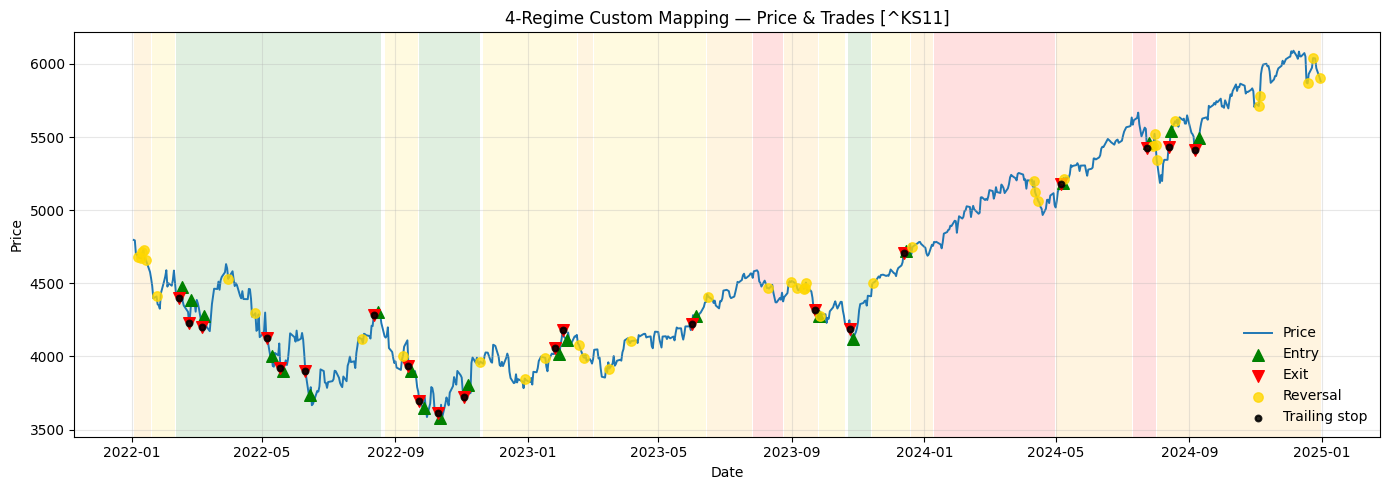

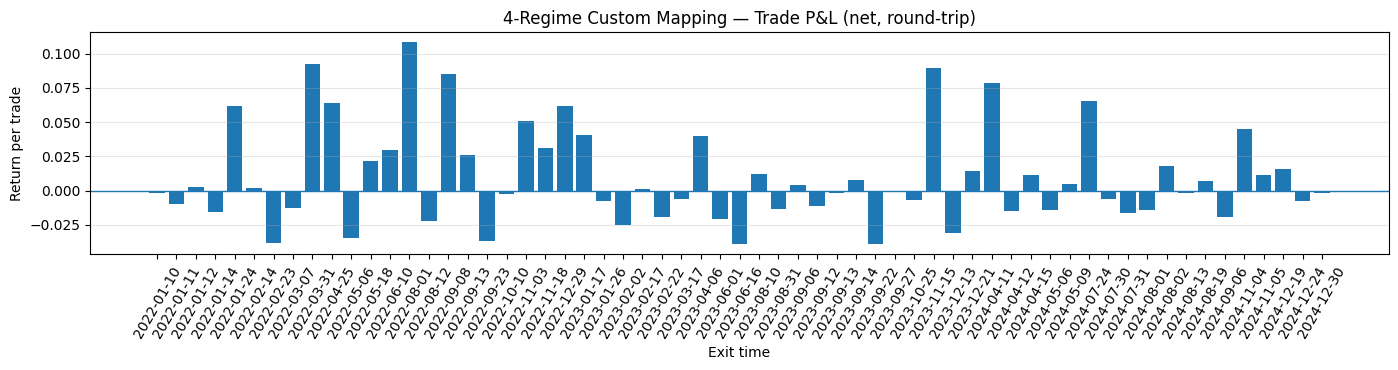

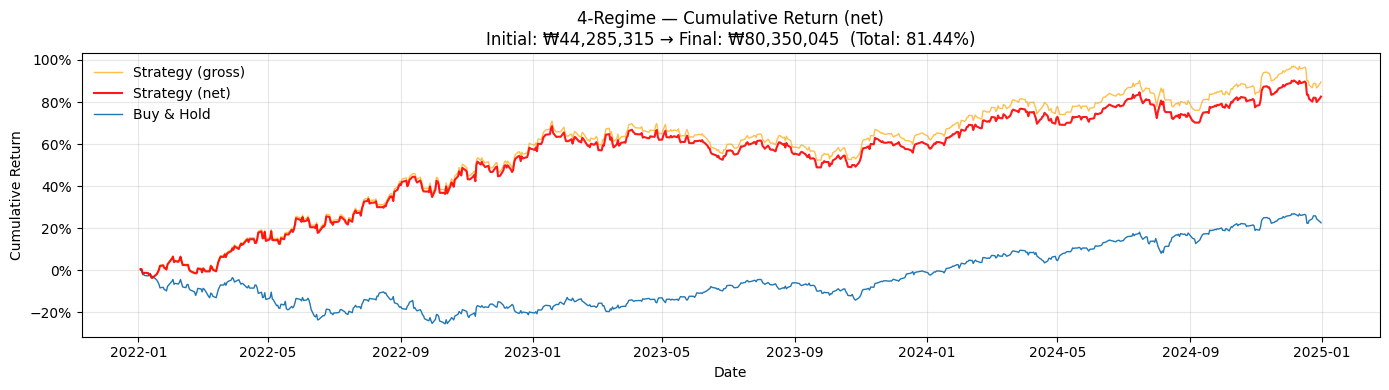

                value
CAGR           0.1335
Sharpe(ann.)   0.8966
Sortino(ann.)  1.3298
Calmar         0.7837
MaxDD         -0.1703
DailyMean      0.0005
DailyStd       0.0096


In [252]:
# =========================
# 1. 백테스트 실행
# =========================
my_config = BTConfig(init_capital=50_000_000.0, fee_bps=2.0, slip_bps=1.0)

bt = run_backtest(
    df_out,
    strategies={
        1: strat_momentum,
        2: strat_momentum,
        3: strat_mean_reversion,
        4: strat_mean_reversion
    },
    config=my_config,        # ✅ 여기서 설정
    exec_shift=1,
    trail_pct=0.04,
    cool_off_days=1,
    start="2022-01-01",
    end="2024-12-31",
    warmup_bars=200
)
# =========================
# 3. 가격 + 거래 시각화
# =========================
rt = plot_backtest_with_trades_rainbow(
    bt, df_out,
    price_col="Close",
    title_prefix="4-Regime Custom Mapping",
    shade_alpha=0.12,
    show_regime=True,
    ticker="^KS11"
)

# =========================
# 4. 누적 수익률 시각화
# =========================
plot_cum_return_after(
    bt,
    title="4-Regime — Cumulative Return (net)",
    show_buyhold=True,
    show_gross_shadow=True,
    show_equity_value=True
)
# =========================
# 5. 요약 통계 출력
# =========================
print(bt["summary"].round(4))
